<a href="https://colab.research.google.com/github/callme-ph/MA/blob/main/Tarefa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefa

1. Teste outras métricas para o [kNN](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics) nos dados SMS Spam Collection Data Set. Qual métrica obteve a melhor acurácia?

2. Carregue o conjunto de dados Optical Recognition of Handwritten Digits (ORHD) do UCI Machine Learning
[link](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

- lembre-se de installar a biblioteca:

!pip install ucimlrepo

- Para carregar a base de dados utilize:

ORHD = fetch_ucirepo(id=80)

- Pré-processe os dados:

features = ORHD.data.features.to_numpy().astype(np.float32) / 16.  # normaliza para o intervalo [0, 1]

targets = ORHD.data.targets.to_numpy().astype(np.int64)

- Transforme os dados (features) em valores binários:

features >= 0.5 deverá ser mapeado para 1

features < 0.5 deverá ser mapeado para 0

- Divida os dados em 2 conjuntos: treinamento (80%) e teste (20%)

- Treine um modelo Naive Bayes (Bernoulli)

- Calcule as acurácias (conjunto de teste) e a matriz de confusão.

3. Treine um modelo k-NN nos mesmos dados Optical Recognition of Handwritten Digits (ORHD) binarizados e compare os resultados com o item 2.

4. Compile seus resultados em no relatório 1 (inclua as figuras e o código em PDF)

## Preparando o ambiente e importando bibliotecas

In [2]:
# Importação das bibliotecas necessárias
!pip install -U ucimlrepo

import numpy as np                                            # Biblioteca para operações numéricas
import pandas as pd                                           # Biblioteca para manipulação de dados em DataFrames
from sklearn.model_selection import train_test_split          # Função para dividir os dados em treino e teste
from sklearn.feature_extraction.text import CountVectorizer   # Transforma texto em representações vetoriais
from sklearn.naive_bayes import BernoulliNB                   # Classificador Naive Bayes com distribuição de Bernoulli
from sklearn.neighbors import KNeighborsClassifier            # Classificador k-NN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Métricas de avaliação
import matplotlib.pyplot as plt                               # Biblioteca de visualização gráfica
import seaborn as sns                                         # Biblioteca de visualização baseada em matplotlib, com estilo melhorado
from ucimlrepo import fetch_ucirepo

# Para figuras geradas pelo matplotlib serem exibidas diretamente no notebook
%matplotlib inline

# 1. Naive Bayes para classificação de Spam

Neste notebook, vamos aplicar o algoritmo Naive Bayes, juntamente com outros algoritmos de classificação, para detectar emails como "Spam" ou "Não-Spam". Em seguida, compararemos o desempenho de cada algoritmo.

A base de dados utilizada é a "SMS Spam Collection", um conjunto de dados amplamente usado para problemas de classificação de texto, especificamente para a detecção de spam em mensagens de SMS.

## Fonte da Base de Dados

A base de dados pode ser encontrada no repositório público da UCI Machine Learning Repository: [SMS Spam Collection Data Set](https://archive.ics.uci.edu/dataset/228/sms+spam+collection).

## Estrutura da Base de Dados

O conjunto de dados contém 5.572 mensagens de SMS rotuladas como "ham" (não-spam) ou "spam". Cada linha no dataset representa uma mensagem de texto, e os dados são organizados em duas colunas:

- label: Indica se a mensagem é "ham" (não-spam) ou "spam".
- message: O texto da mensagem de SMS.

Exemplo de Dados
Aqui estão alguns exemplos de entradas no dataset:


'ham', 'Go until jurong point, crazy.. Available only in bugis n great world..'

'ham', 	'Ok lar... Joking wif u oni...'

'spam',	'Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005.'

'ham', 'U dun say so early hor... U c already then say...'


## Passos:
1. Carregar e visualizar os dados
2. Pré-processamento dos dados
3. Treinar diferentes modelos de classificação
4. Avaliar e comparar o desempenho dos modelos

## Carregando e Visualizando os Dados

Vamos carregar o dataset de spam e visualizar as primeiras linhas.


In [3]:
# Carregamento do dataset de spam
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

# Visualização dos dados
print("Visualização das primeiras linhas do dataset:")
display(df.head(11))

Visualização das primeiras linhas do dataset:


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## Pré-processamento dos Dados

Vamos converter as labels para valores binários e dividir os dados em conjuntos de treino e teste.

In [4]:
# Exemplo do CountVectorizer

# Frases de treino
X_train = [
    "maçã e banana",
    "banana é boa",
    "eu gosto de maçã",
    "banana e maçã são frutas"
]

# Frases de teste
X_test = [
    "eu gosto de banana",
    "laranja é uma fruta",
    "maçã verde é azeda"
]

# Inicialização do vetor com binarização
vectorizer = CountVectorizer(binary=True)  # binary=True: CountVectorizer marca apenas se uma palavra apareceu (1) ou não apareceu (0) em um determinado documento, sem contar quantas vezes ela apareceu.

# Ajuste + transformação do treino
X_train_vec = vectorizer.fit_transform(X_train)  # matriz esparsa

# Somente transformação do teste com o mesmo vocabulário
X_test_vec = vectorizer.transform(X_test)       # matriz esparsa

# Criação dos DataFrames para visualização
df_train = pd.DataFrame(
    X_train_vec.toarray(),  # Transforma em matriz densa
    columns=vectorizer.get_feature_names_out(),
    index=[f"treino_{i+1}" for i in range(len(X_train))]
)

df_test = pd.DataFrame(
    X_test_vec.toarray(),   # Transforma em matriz densa
    columns=vectorizer.get_feature_names_out(),
    index=[f"teste_{i+1}" for i in range(len(X_test))]
)

# Visualizações
print("Vocabulário aprendido:")
print(vectorizer.get_feature_names_out())

print("\nMatriz binária - Dados de treino:")
display(df_train)

print("\nMatriz binária - Dados de teste:")
display(df_test)  # Usa o mesmo vocabulário aprendido no fit do treino, e ignora palavras desconhecidas



Vocabulário aprendido:
['banana' 'boa' 'de' 'eu' 'frutas' 'gosto' 'maçã' 'são']

Matriz binária - Dados de treino:


,banana,boa,de,eu,frutas,gosto,maçã,são
treino_1,1,0,0,0,0,0,1,0
treino_2,1,1,0,0,0,0,0,0
treino_3,0,0,1,1,0,1,1,0
treino_4,1,0,0,0,1,0,1,1



Matriz binária - Dados de teste:


,banana,boa,de,eu,frutas,gosto,maçã,são
teste_1,1,0,1,1,0,1,0,0
teste_2,0,0,0,0,0,0,0,0
teste_3,0,0,0,0,0,0,1,0


In [5]:
# Conversão das labels para valores binários
# Spams serão classificados como 1 e não spams serão 0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(  # Divide dados em treino (70%) e teste (30%)
    df['message'],  # Variável independente: textos das mensagens
    df['label'],    # Variável dependente: rótulo binário
    test_size=0.3,  # Proporção de teste: 30%
    random_state=42 # Semente para reprodutibilidade dos resultados
)

# Transformação dos textos em vetores de contagem de palavras (binário)
vectorizer = CountVectorizer(binary=True)         # Inicializa o vetor com contagem binária (presença/ausência da palavra)
X_train_vec = vectorizer.fit_transform(X_train)   # Ajusta e transforma os dados de treino em vetores binários
X_test_vec = vectorizer.transform(X_test)         # Transforma os dados de teste com o mesmo vocabulário aprendido no treino

X_train, X_train_vec

(708     Quite late lar... Ard 12 anyway i wun b drivin...
 4338                        on a Tuesday night r u 4 real
 5029    Go chase after her and run her over while she'...
 4921     G says you never answer your texts, confirm/deny
 2592         Still work going on:)it is very small house.
                               ...                        
 3772    Hi, wlcome back, did wonder if you got eaten b...
 5191                               Sorry, I'll call later
 5226        Prabha..i'm soryda..realy..frm heart i'm sory
 5390                           Nt joking seriously i told
 860               Did he just say somebody is named tampa
 Name: message, Length: 3900, dtype: object,
 <Compressed Sparse Row sparse matrix of dtype 'int64'
 	with 52150 stored elements and shape (3900, 7263)>)

In [6]:
feature_names = vectorizer.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_vec.toarray(),
                          columns=feature_names)
print(f'"Vocabulário aprendido:{feature_names}\n')
display(X_train_df.head())

"Vocabulário aprendido:['00' '000' '000pes' ... 'zouk' 'zyada' 'èn']



,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,02,0207,...,zed,zeros,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Naive Bayes

O algoritmo Naive Bayes é um método probabilístico de classificação baseado no Teorema de Bayes. Ele é chamado de "naive" (ingênuo) porque assume que todas as características (ou atributos) são independentes entre si, dado a classe. Embora essa suposição de independência raramente seja verdadeira na prática, o algoritmo tem se mostrado eficaz em muitos cenários, especialmente na classificação de texto.

Teorema de Bayes
O Teorema de Bayes é a base matemática do Naive Bayes e é expresso da seguinte forma:

$P(A|B)= \frac{P(B|A)\cdot P(A)}{P(B)}$

em que:

- $P(A|B)$ é a probabilidade posterior de $A$ dado $B$.
- $P(B|A)$ é a probabilidade de $B$ dado $A$.
- $P(A)$ é a probabilidade a priori de $A$.
- $P(B)$ é probabilidade de $B$.

No contexto da classificação, o algoritmo calcula a probabilidade de um dado pertencer a uma classe com base nas características observadas. O classificador Naive Bayes usa o Teorema de Bayes com a suposição de independência condicional para calcular a probabilidade posterior de cada classe. A classe com a maior probabilidade posterior é escolhida como a classe predita.

## Equação do Naive Bayes

Para um conjunto de características $X = (X_1, X_2, ..., X_n)$ e uma classe  $Y$, a fórmula do Naive Bayes é:

$ P(Y|X) \propto P(Y) \cdot P(X_1|Y) \cdot P(X_2|Y) \cdot ... \cdot P(X_n|Y) $

Aqui:
- $P(Y)$ é a probabilidade anterior da classe $Y$.
- $P(X_i|Y)$ é a probabilidade condicional da característica $X_i$ dada a classe $Y$.

#### Passos do Algoritmo Naive Bayes

1. **Treinamento:**
   - Calcular as probabilidades anteriores das classes $P(Y)$.
   - Calcular as probabilidades condicionais $P(X_i|Y)$ para cada característica $X_i$ dado cada classe $Y$.

2. **Classificação:**
   - Para um novo exemplo, calcular a probabilidade posterior de cada classe.
   - A classe com a maior probabilidade posterior é escolhida como a classe predita.

Vamos agora treinar o modelo Bernoulli Naive Bayes.


Precisão do modelo Bernoulli Naive Bayes: 0.9791
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       1.00      0.84      0.92       224

    accuracy                           0.98      1672
   macro avg       0.99      0.92      0.95      1672
weighted avg       0.98      0.98      0.98      1672



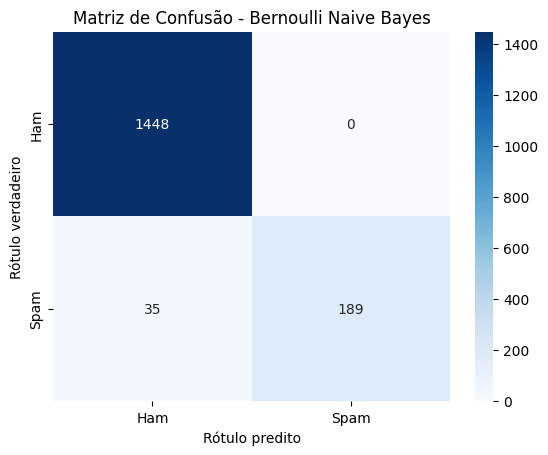

In [7]:
# Treinamento do modelo Bernoulli Naive Bayes
nb_model = BernoulliNB()            # Cria uma instância do classificador Naive Bayes com distribuição de Bernoulli (para dados binários)
nb_model.fit(X_train_vec, y_train)  # Treina o modelo usando os vetores binários de treino e os rótulos correspondentes (0 = ham, 1 = spam)

# Previsão e avaliação do modelo
y_pred_nb = nb_model.predict(X_test_vec)          # Faz predições com base nos vetores de teste
accuracy_nb = accuracy_score(y_test, y_pred_nb)   # Calcula a acurácia comparando as predições com os rótulos reais
print(f"Precisão do modelo Bernoulli Naive Bayes: {accuracy_nb:.4f}")  # Exibe a precisão do modelo com 4 casas decimais

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_nb))  # Exibe métricas como precisão, recall e F1-score para cada classe (ham e spam)

# Matriz de confusão
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)  # Gera a matriz de confusão: compara rótulos reais e previstos
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])  # Cria um mapa de calor da matriz de confusão, com rótulos
plt.ylabel('Rótulo verdadeiro')
plt.xlabel('Rótulo predito')
plt.title('Matriz de Confusão - Bernoulli Naive Bayes')
plt.show()

## Treinando Diferentes Modelos de Classificação

Vamos treinar o modelo Bernoulli Naive Bayes e outros algoritmos de classificação, como kNN para comparação.


In [8]:
# Treinamento dos modelos
models = {
    "K-NN Euclidean": KNeighborsClassifier(metric="euclidean"),
    "K-NN Minkowski": KNeighborsClassifier(metric="minkowski"),
    "K-NN Cityblock": KNeighborsClassifier(metric="cityblock"),
    "K-NN Cosine": KNeighborsClassifier(metric="cosine"),
    "K-NN Manhattan": KNeighborsClassifier(metric="manhattan"),
    "Bernoulli Naive Bayes": BernoulliNB()
}

# Treinamento e avaliação de cada modelo
results = {"Bernoulli Naive Bayes": {"accuracy": accuracy_nb, "classification_report": classification_report(y_test, y_pred_nb), "confusion_matrix": conf_matrix_nb}}
for model_name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = {
        "accuracy": accuracy,
        "classification_report": classification_report(y_test, y_pred),
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }
    print(f"Modelo: {model_name}")
    print(f"Precisão: {accuracy:.4f}")
    print("Relatório de Classificação:")
    print(results[model_name]["classification_report"])
    print("Matriz de Confusão:")
    print(results[model_name]["confusion_matrix"])
    print("-" * 60)


Modelo: K-NN Euclidean
Precisão: 0.9145
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1448
           1       1.00      0.36      0.53       224

    accuracy                           0.91      1672
   macro avg       0.96      0.68      0.74      1672
weighted avg       0.92      0.91      0.90      1672

Matriz de Confusão:
[[1448    0]
 [ 143   81]]
------------------------------------------------------------
Modelo: K-NN Minkowski
Precisão: 0.9145
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1448
           1       1.00      0.36      0.53       224

    accuracy                           0.91      1672
   macro avg       0.96      0.68      0.74      1672
weighted avg       0.92      0.91      0.90      1672

Matriz de Confusão:
[[1448    0]
 [ 143   81]]
-------------------------------------------------------

## Comparando o Desempenho dos Modelos

Vamos comparar o desempenho dos modelos usando a precisão e visualizando as matrizes de confusão.


,Accuracy
Bernoulli Naive Bayes,0.979067
K-NN Cosine,0.976077
K-NN Euclidean,0.914474
K-NN Minkowski,0.914474
K-NN Cityblock,0.914474
K-NN Manhattan,0.914474


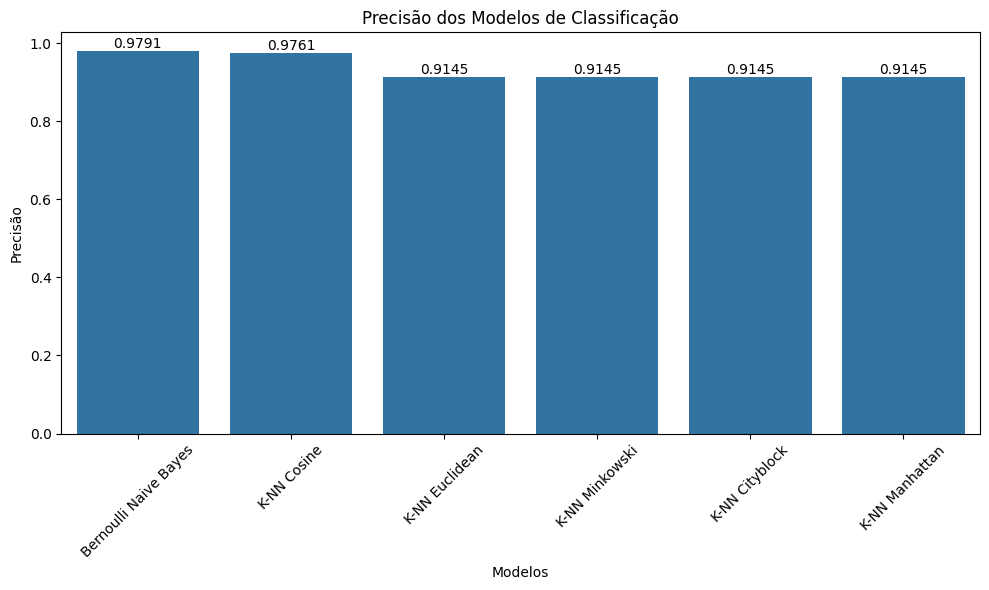

In [9]:
# Comparação da precisão dos modelos
accuracies = {model_name: result["accuracy"] for model_name, result in results.items()}
accuracies_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy'])
accuracies_df = accuracies_df.sort_values(by='Accuracy', ascending=False)
display(accuracies_df)

# Visualização das precisões
plt.figure(figsize=(10, 6))
ax = barplot = sns.barplot(x=accuracies_df.index, y=accuracies_df['Accuracy'])
plt.title('Precisão dos Modelos de Classificação')
plt.ylabel('Precisão')
plt.xlabel('Modelos')
plt.xticks(rotation=45)

# # Adicionando os valores das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.tight_layout()
plt.show()

O modelo de Bernoulli Naive Bayes, para datasets binários se mostrou bem eficiente para tarefa de caracterização de SPAM ou HAM.

## Matriz de Confusão dos Modelos

Vamos visualizar a matriz de confusão para cada modelo.


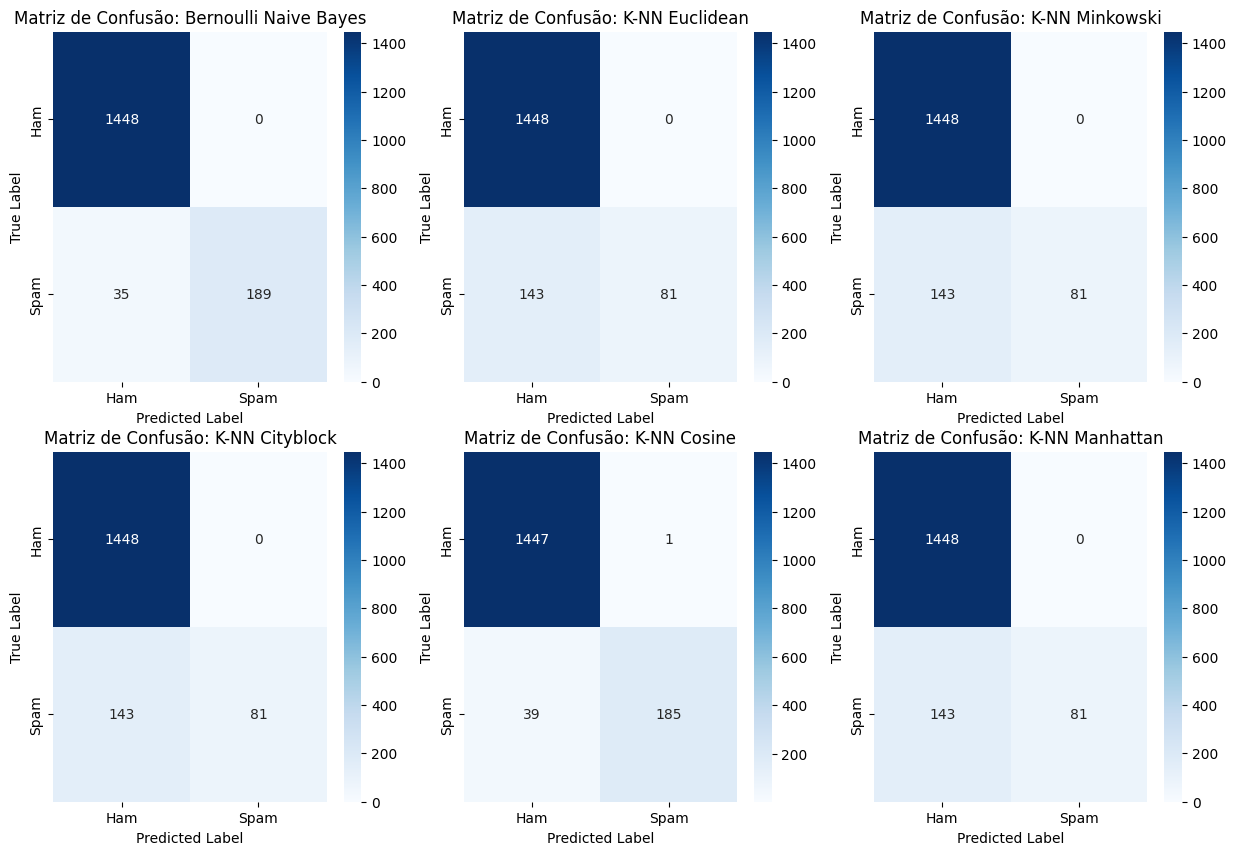

In [10]:
# Visualização das matrizes de confusão
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (model_name, result) in enumerate(results.items()):
    sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=axes[i])
    axes[i].set_title(f'Matriz de Confusão: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

#plt.tight_layout(h_pad=3.0)
plt.show()

## Conclusão

O método de classificação usando o método Naive Bayes de Bernoulli é o que tem melhor acurácia em comparação com o K-Nearest Neighbors mesmo com diferentes métricas para o cálculo da distância. A métrica que proporcionou uma acurácia mais próxima do Naive Bayes foi a **Cosine**. Seria necessário, porém, para validar que o Naive Bayes é mais eficiente para este problema, testar os diferentes modelos KNN com diferente valores de K - vizinhos, pois como visto na primeira tarefa, os valores de K usado no modelo pode interferir na acurácia da classificação. Para os modelos criado sem definição explicíta dos valores de K, o modelo usa K = 5 por padrão.

# 2. ORHD

In [11]:
# Carregando a base de dados
ORHD = fetch_ucirepo(id=80)

# Ajustando dados
features = ORHD.data.features.to_numpy().astype(np.float32) / 16. # Normaliza os valores de features para o intervalo [0, 1]
targets = ORHD.data.targets.to_numpy().astype(np.int64) # Salva os valore de targets em um array de inteiros do tipo int64.

features = (features >= 0.5).astype(int) # Transformando os valores de features em binário

print(f'features shape = {features.shape}')
print(f'targets unique = {np.unique(targets)}')

# Particionando o dataset em conjuntos de teste e treino
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

[[0]
 [0]
 [7]
 ...
 [8]
 [9]
 [8]]
features shape = (5620, 64)
targets unique = [0 1 2 3 4 5 6 7 8 9]


Precisão do modelo Bernoulli Naive Bayes: 0.8915
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.82      0.82      0.82       102
           2       0.97      0.88      0.92       107
           3       0.94      0.86      0.89       118
           4       0.92      0.88      0.90       117
           5       0.89      0.88      0.88        97
           6       0.96      0.96      0.96       123
           7       0.88      0.98      0.93       124
           8       0.76      0.85      0.80       105
           9       0.81      0.82      0.81       123

    accuracy                           0.89      1124
   macro avg       0.89      0.89      0.89      1124
weighted avg       0.89      0.89      0.89      1124



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Matriz de Confusão - Bernoulli Naive Bayes')

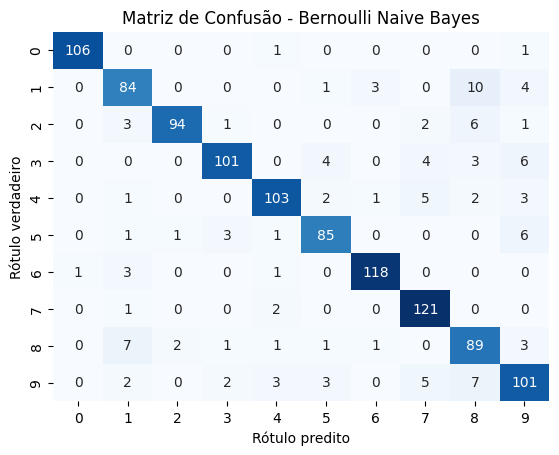

In [16]:
# Inicializando, treinando e usando um modelo de Bernoulli Naive Bayes para o dataset ORHD

NB = BernoulliNB()
NB.fit(X_train, Y_train)
y_pred = NB.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Precisão do modelo Bernoulli Naive Bayes: {accuracy:.4f}")

clr = classification_report(Y_test, y_pred)
print("Relatório de Classificação:")
print(clr)

conf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(targets), yticklabels=np.unique(targets), cbar=False)
plt.ylabel('Rótulo verdadeiro')
plt.xlabel('Rótulo predito')
plt.title('Matriz de Confusão - Bernoulli Naive Bayes')

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(1124,)
(1124, 1)
------------------------------------------------------------
(1124,)
(1124, 1)


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(1124,)
(1124, 1)
------------------------------------------------------------
(1124,)
(1124, 1)


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(1124,)
(1124, 1)
------------------------------------------------------------
(1124,)
(1124, 1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------------------------------------


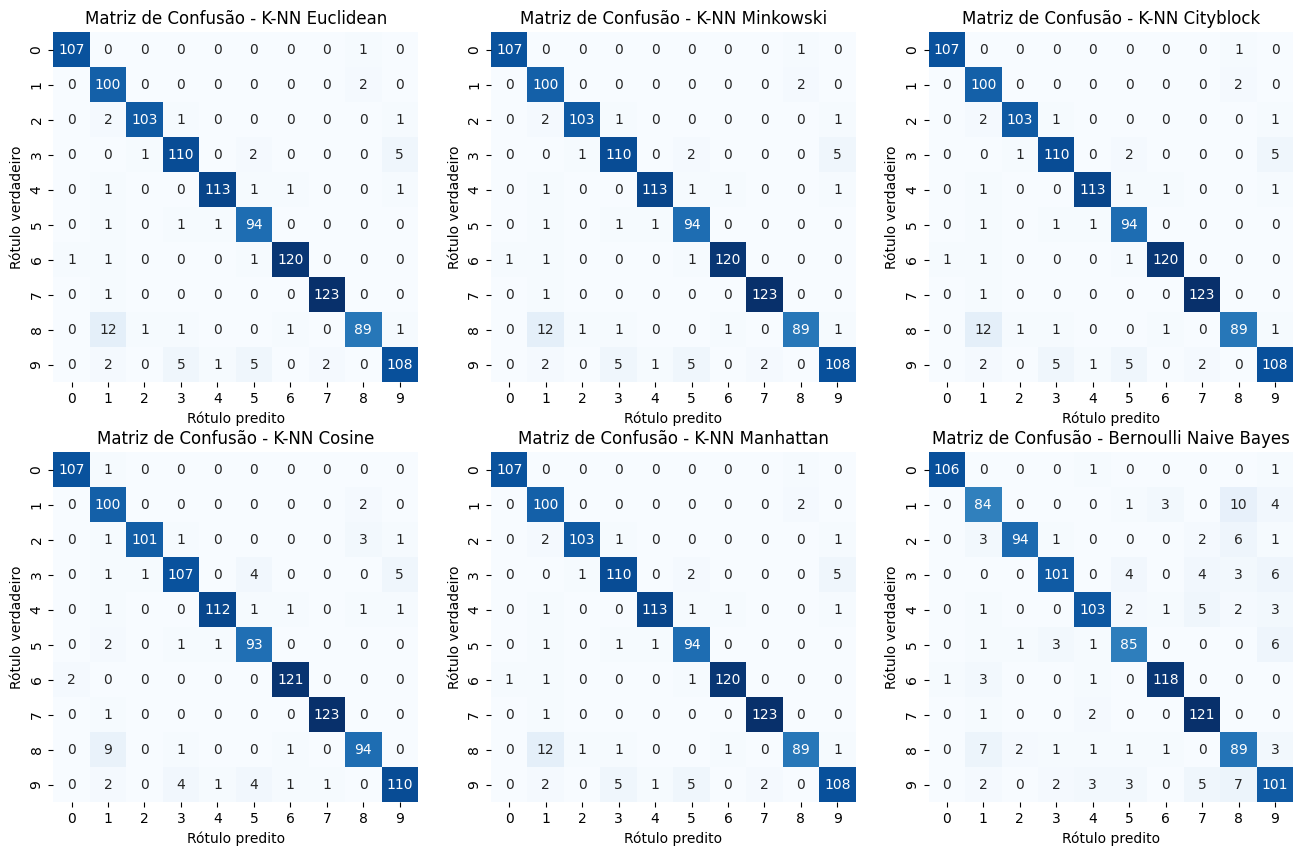

In [23]:
## Treinando os modelos KNN para treinamento, teste e avaliação.

# Treinamento dos modelos
models = {
    "K-NN Euclidean": KNeighborsClassifier(metric="euclidean"),
    "K-NN Minkowski": KNeighborsClassifier(metric="minkowski"),
    "K-NN Cityblock": KNeighborsClassifier(metric="cityblock"),
    "K-NN Cosine": KNeighborsClassifier(metric="cosine"),
    "K-NN Manhattan": KNeighborsClassifier(metric="manhattan"),
    "Bernoulli Naive Bayes": BernoulliNB()
}


fig, axes = plt.subplots(int((len(models)/2)-1), int(len(models)/2), figsize=(16, 10))
axes = axes.flatten()
acc = []

# Treinamento e avaliação de cada modelo

results = {"Bernoulli Naive Bayes": {"accuracy": accuracy_nb, "classification_report": classification_report(y_test, y_pred_nb), "confusion_matrix": conf_matrix_nb}}
for i, (model_name, model) in enumerate(models.items()):

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    print(np.shape(y_pred))
    print(np.shape(Y_test))
    accuracy = accuracy_score(Y_test, y_pred)
    acc.append((model_name, accuracy))
    results[model_name] = {
        "accuracy": accuracy,
        "classification_report": classification_report(Y_test, y_pred),
        "confusion_matrix": confusion_matrix(Y_test, y_pred)
    }
    #print(f"Modelo: {model_name}")
    #print(f"Precisão: {accuracy:.4f}")
    #print("Relatório de Classificação:")
    #print(results[model_name]["classification_report"])
    #print("Matriz de Confusão:")
    sns.heatmap(results[model_name]["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(targets), yticklabels=np.unique(targets),
                cbar=False, ax=axes[i])
    axes[i].set_ylabel('Rótulo verdadeiro')
    axes[i].set_xlabel('Rótulo predito')
    axes[i].set_title(f'Matriz de Confusão - {model_name}')

    print("-" * 60)

plt.show()

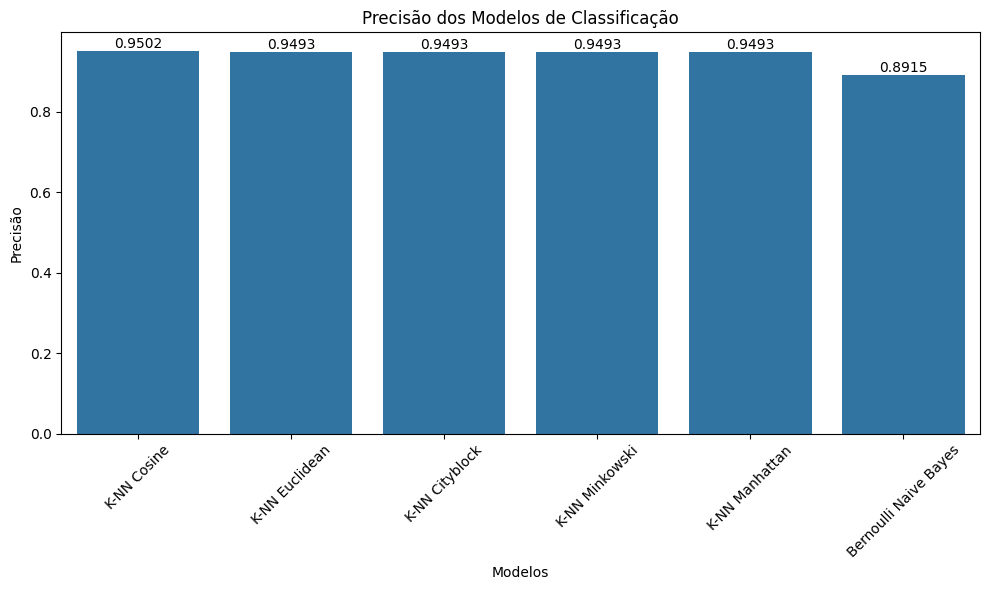

In [14]:
# Visualização das precisões
plt.figure(figsize=(10, 6))

# Convertendo resultad
accuracies_df = pd.DataFrame.from_dict({model_name: result["accuracy"] for model_name, result in results.items()}, orient='index', columns=['Accuracy'])

# Sort values by accuracy
accuracies_df = accuracies_df.sort_values(by='Accuracy', ascending=False)

# Create bar plot
ax = barplot = sns.barplot(x=accuracies_df.index, y=accuracies_df['Accuracy'])
plt.title('Precisão dos Modelos de Classificação')
plt.ylabel('Precisão')
plt.xlabel('Modelos')
plt.xticks(rotation=45)

# # Adicionando os valores das barras
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')

plt.tight_layout()
plt.show()